# Image Compression using K-Means Clustering

In this notebook, we will implement the K-means algorithm and use it for image compression. We first start on an example 2D dataset that will help us to gain an intuition of how the K-means algorithm works. After that, we will use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most
common in that image.

## Implementing K-Means

The K-means algorithm is a method to automatically cluster similar data examples together. We are given a training set {$x^{(1)}, ... , x^{(m)}$}, (where $x^{(i)} \in R^n$), and want to group the data into a few cohesive "clusters".
The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:
    * Assigning each training example x(i) to its closest centroid
    * Recomputing the mean of each centroid using the points assigned to it.

The K-means algorithm will always converge to some final set of means for the centroids. The converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

### Finding closest centroids

In the "cluster assignment" phase of the K-means algorithm, the algorithm assigns every training example x(i) to its closest centroid, given the current positions of centroids. Specifically, for every example 'i', we set:

$$ c^{(i)}:=j, \; that \; minimizes \; ||x{(i)}-\mu_j ||^2 $$ 

where $c^{(i)}$ is the index of the centroid that is closest to x(i), and $\mu_j$ is the position (value) of the j'th centroid.

First, lets load the dataset 

In [21]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as opt
from scipy.io import loadmat
from scipy.optimize import minimize

from mpl_toolkits import mplot3d

from IPython.core.debugger import set_trace
from IPython.display import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn import svm 

%matplotlib inline

In [22]:
# Load the dataset
dataset = loadmat('data2.mat')  
dataset

{'X': array([[ 1.84207953,  4.6075716 ],
        [ 5.65858312,  4.79996405],
        [ 6.35257892,  3.2908545 ],
        [ 2.90401653,  4.61220411],
        [ 3.23197916,  4.93989405],
        [ 1.24792268,  4.93267846],
        [ 1.97619886,  4.43489674],
        [ 2.23454135,  5.05547168],
        [ 2.98340757,  4.84046406],
        [ 2.97970391,  4.80671081],
        [ 2.11496411,  5.37373587],
        [ 2.12169543,  5.20854212],
        [ 1.5143529 ,  4.77003303],
        [ 2.16979227,  5.27435354],
        [ 0.41852373,  4.88312522],
        [ 2.47053695,  4.80418944],
        [ 4.06069132,  4.99503862],
        [ 3.00708934,  4.67897758],
        [ 0.66632346,  4.87187949],
        [ 3.1621865 ,  4.83658301],
        [ 0.51155258,  4.91052923],
        [ 3.1342801 ,  4.96178114],
        [ 2.04974595,  5.6241395 ],
        [ 0.66582785,  5.24399257],
        [ 1.01732013,  4.84473647],
        [ 2.17893568,  5.29758701],
        [ 2.85962615,  5.26041997],
        [ 1.30882588,  

In [23]:
X = dataset['X']

# Print the shape of X
X.shape

(300, 2)

Now we will plot the data to see how the data points are scattered

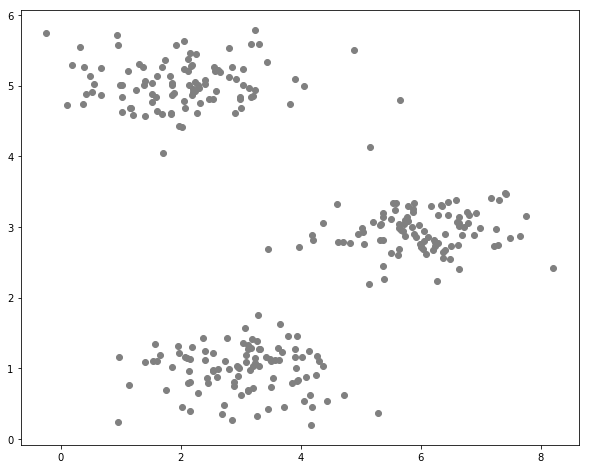

In [24]:
fig, ax = plt.subplots(figsize=(10,8))  
ax.scatter(X[:,0], X[:,1], c='gray', marker='o') 

plt.show()

We can see from the plot that there are 3 different clusters in this dataset.

Now we will define a function "findClosestCentroids" which takes the data matrix X and the locations of all centroids inside
"centroids". This function should return a one-dimensional array "idx" that holds the index (a value in {1, ... ,K}, where K is total number of centroids) of the closest centroid to every training example.

In [25]:
def findClosestCentroids(X, centroids):  
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)

    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j

    return idx

Let's test the function to make sure it's working as expected.

In [26]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = findClosestCentroids(X, initial_centroids)  
idx

array([ 0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

The centroid closest to each data point is displayed as indexes in the output shown above.

### Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set

$$ \mu_k:= \frac{1}{|C_k|} \sum_{i \in C_k}x^{(i)} $$

where Ck is the set of examples that are assigned to centroid k. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid k = 2, then we should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)})$

In [27]:
def computeCentroids(X, idx, k):  
    m, n = X.shape
    centroids = np.zeros((k, n))

    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()

    return centroids

In [28]:
# Call the function with k=3
computeCentroids(X, idx, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

### K-Means implementation for the above dataset

Next step is to create a function that runs K-means on a 2D dataset using the functions defined above.

In [29]:
def runKMeans(X, initial_centroids, max_iters):  
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids

    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, k)

    return idx, centroids

In [30]:
idx, centroids = runKMeans(X, initial_centroids, 10)  

# Print the Indexes and Centroids
idx, centroids

(array([ 0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

Lets visualize the cluster assignments

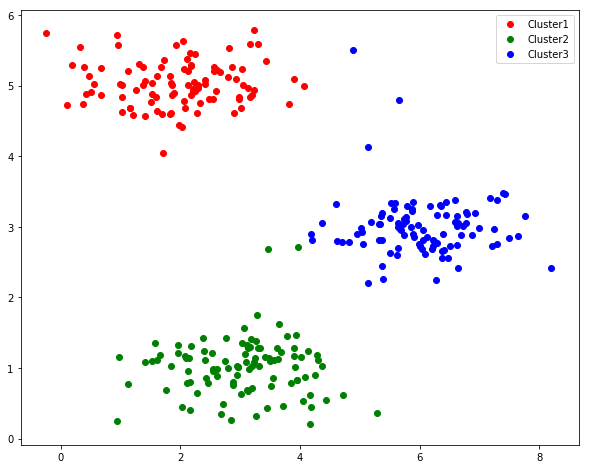

In [31]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(10,8))  
ax.scatter(cluster1[:,0], cluster1[:,1], c='r', marker='o', label='Cluster1')  
ax.scatter(cluster2[:,0], cluster2[:,1], c='g', marker='o', label='Cluster2') 
ax.scatter(cluster3[:,0], cluster3[:,1], c='b', marker='o', label='Cluster3') 

ax.legend(loc='upper right')

plt.show()

#### Random Initialization of Centroids

In practice, a good strategy for initializing the centroids is to select random examples from the training set.

The code below first randomly permutes the indices of the examples. Then, it selects the first K examples based on the random
permutation of the indices. This allows the examples to be selected at random without the risk of selecting the same example twice.

In [32]:
def initCentroids(X, k):  
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)

    for i in range(k):
        centroids[i,:] = X[idx[i],:]

    return centroids

In [33]:
init_centroids = initCentroids(X, 3)
init_centroids

array([[ 3.16109021,  1.29422893],
       [ 3.18412176,  1.41410799],
       [ 6.63060699,  3.01502301]])

## Image Compression using K-Means

Now lets apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and here, we will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an effcient way. Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

We will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once we have computed the cluster centroids on the image, we can then use the 16 colors to replace the pixels in the original image.

In [34]:
# Load the image data
image_data = loadmat('bird_small.mat') 
A = image_data['A']

# Print the RGB encoding at 50th row and 33rd column
A[50,33]

array([175, 124,  50], dtype=uint8)

This creates a three-dimensional matrix A whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A(50, 33, 2) gives the blue intensity of the pixel at row 50 and column 33.

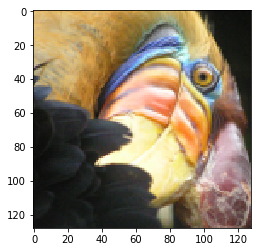

In [35]:
# Create the picture using the pixel data stored in 'A'
plt.imshow(A)

In [36]:
# Print the shape of 'A'
A.shape

(128, 128, 3)

### Data pre-processing

In [37]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape 

(16384, 3)

In [38]:
# Randomly initialize the centroids
initial_centroids = initCentroids(X, 16)

# Run the algorithm
idx, centroids = runKMeans(X, initial_centroids, 10)

# Get the closest centroids one last time
idx = findClosestCentroids(X, centroids)

# Map each pixel to the centroid value
X_reconstructed = centroids[idx.astype(int),:]

# Reshape to the original dimensions
X_reconstructed = np.reshape(X_reconstructed, (A.shape[0], A.shape[1], A.shape[2]))
X_reconstructed.shape


(128, 128, 3)

After finding the top K = 16 colors to represent the image, we can now assign each pixel position to its closest centroid using the "findClosestCentroids" function. This allows us to represent the original image using the centroid assignments of each pixel. Notice that we have significantly reduced the number of bits that are required to describe the image. The original image
required 24 bits for each one of the 128 x 128 pixel locations, resulting in total size of 128 x 128 x 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 x 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

#### Reconstruct the image

Finally, we can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, we can replace each pixel location with the mean of the centroid assigned to it. The following image
shows the reconstruction we obtained. Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

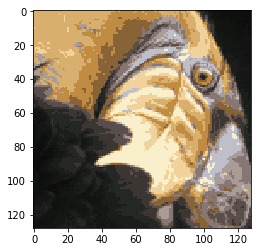

In [39]:
plt.imshow(X_reconstructed)
plt.show()